# Recovering Molar Mass Distributions

### Assuming Gaussian Distribution
In this cell, we assume the molar masses are normally distributed. Our goal is to take in any two of $M_n$, $M_w$, and the $PDI$ ($PDI=\frac{M_w}{M_n}$)

We can analytically solve the integral expressions for $M_n$ and $M_w$ to find the correct $\sigma$ value for our Gaussian distribution, which reveals that $\sigma = M_n(M_w - M_n)$ 

In [5]:
import numpy as np
import matplotlib.pyplot as plt

M_n: 50.0
M_w: 55.803129302993376
Recovered sigma: 290.1564651496688
Actual sigma: 301.0
76.47301319723567


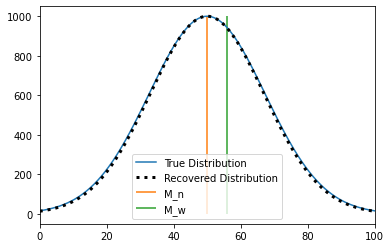

In [19]:

# With numerical integration, we don't recover exact sigma, but the distribution is close
x_max = 100
N = 1e3
sigma = 301.
x = np.linspace(0, x_max, round(N)+1)
y = N*np.exp(-(x-50.)**2/(2.*sigma))
M_n = np.sum(np.multiply(x,y))/np.sum(y)
# Notice if we replace the numerical integral with analytical form of M_w, we get exact agreement
M_w = np.sum(y*x**2)/np.sum(y*x)# (M_n**2 + sigma)/M_n
plt.plot(x, y, label='True Distribution')
plt.xlim(0, 100.)
plt.vlines(M_n, 0, N, 'C1', label='M_n')
plt.vlines(M_w, 0, N, 'C2', label='M_w')

def recovered_gauss_sigma(Mn, Mw):
    return Mn * (Mw - Mn)

def gauss(x, mu, sigma, N=1000):
    return N * np.exp(-(x - mu)**2 / (2. * sigma))

recovered_sig = recovered_gauss_sigma(M_n, M_w)

print(f'M_n: {M_n}\nM_w: {M_w}\nRecovered sigma: {recovered_sig}\nActual sigma: {sigma}')


y2 = gauss(x, mu=M_n, sigma=recovered_sig, N=N)
plt.plot(x,y2, ':', lw=3, color='k', label='Recovered Distribution')
plt.legend()
#plt.savefig('gaussian_mass_dist_true.svg')
mse = np.mean((y2-y)**2)
print(mse)

Let's see how our error scales as a function of the number of data points.

[0.7058724306388201, 0.7358354448644935, 0.746001904047329, 0.7511188580538044, 0.7541998482585397, 0.7603862143493916, 0.7653587607673752, 0.7659817971558542, 0.766480461345451, 0.7665428090638243, 0.7665926895900458, 0.7665989248027029, 0.7666039129962168, 0.7666045365230392]


Text(0, 0.5, 'M%E')

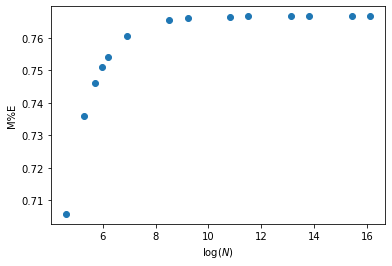

In [18]:
N_vals = [1e2, 2e2, 3e2, 4e2, 5e2, 1e3, 5e3, 1e4, 5e4, 1e5, 5e5, 1e6, 5e6, 1e7]
mse_vals = []
sigma = 301.
for N in N_vals:
    N = round(N)
    x = np.linspace(0, x_max, N+1)
    y = N * np.exp(-(x - 50.)**2 / (2. * sigma))
    M_n = np.sum(np.multiply(x, y)) / np.sum(y)
    M_w = np.sum(y * x**2)/np.sum(y * x)# (M_n**2 +  sigma)/M_n
    recovered_sigma = M_n * (M_w - M_n)
    y2 = N * np.exp(-(x - 50.)**2 / (2. * recovered_sigma))
    mse_vals.append(np.mean( (100.*(np.abs(y2 - y)/N)) ))
print(mse_vals)
plt.plot(np.log(N_vals), mse_vals, 'o')
plt.xlabel('log($N$)')
plt.ylabel('M%E')
#plt.savefig('gaussian_mse.svg')

### Assuming Weibull Distribution
That worked, so now let's try with a [Weibull distribution](https://en.wikipedia.org/wiki/Weibull_distribution)
The expression for a Webull distribution has two parameters, $k$ and $\lambda$, which are the **shape** and **scale** paramters, respectively.
It is: $f(x;\lambda,k) = \frac{k}{\lambda}(\frac{x}{\lambda}^(k-1)e^{-(x/\lambda)^k}$ for $x\ge0$ and $0$ for $x<0$.

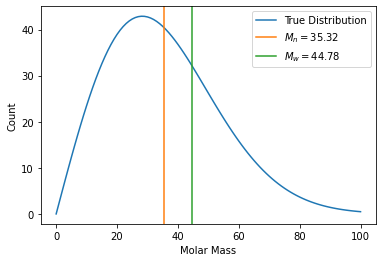

In [37]:
# Weibull distribution
def weib(x, shape=1., scale=1., coeff=1.):
    return coeff * ( shape / scale * (x / scale) ** (shape - 1) * np.exp(- (x / scale) ** shape) )
x = np.linspace(0., 100., 101)
scale = 40.
shape = 2.
plt.figure()
plt.plot(x, weib(x, shape, scale, coeff=2000), label='True Distribution')
y = weib(x, shape, scale)
weib_M_n = np.sum(x*y) / np.sum(y)
plt.axvline(x=weib_M_n, color="C1", label=f'$M_n={weib_M_n:.4}$')
weib_M_w = np.sum(x**2 * y) / np.sum(x*y)
plt.axvline(x=weib_M_w, color="C2", label=f'$M_w={weib_M_w:.4}$')

plt.xlabel('Molar Mass')
plt.ylabel('Count')
plt.legend()
#plt.savefig('weibull_mass_dist_true.svg')


Unlike the Gaussian, there is no analytic solution for the Weibull distribution's parameters. We can find the expression for how they relate but trying to solve leads to a transcendental expression for $k$ or $\lambda$. However, we can just solve numerically.

the predicted value of lambda with k=2 is: 39.85564436657072 (should be ~40)
recovered k: [2.02200446]
recovered lambda: [39.863006]


/home/rainier/anaconda3/envs/uli/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/rainier/anaconda3/envs/uli/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  


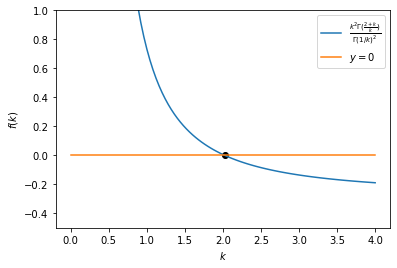

In [38]:
from scipy.special import gamma
import scipy.optimize
# expression for k, the shape factor ('x' here)
# the point where this function reaches zero is the correct k value
def f1(x, Mn, Mw):
    return (2. * x * gamma(2./x)) / gamma(1./x)**2 - (Mw / Mn)

def f2(Mn, k):
    return(Mn * k / gamma(1./k))

# if we *know* the k value, does our expression for lambda hold? (should be ~40)
print('the predicted value of lambda with k=2 is:', weib_M_n * 2. / gamma(0.5), '(should be ~40)')
# good

xrange = np.linspace(0,4,101)
plt.figure()
plt.plot(xrange,f1(xrange,weib_M_n, weib_M_w), label=r'$\frac{k^2 \Gamma(\frac{2+k}{k})}{\Gamma(1/k)^2}$')
plt.plot(xrange, np.zeros_like(xrange), label='$y=0$')
plt.ylim(-0.5,1)
plt.legend()
plt.xlabel('$k$')
plt.ylabel('$f(k)$')

# try numeric solver
a=scipy.optimize.root(f1, args=(weib_M_n, weib_M_w), x0=1.)
recovered_k = a['x']
print('recovered k:', recovered_k)
# Now that we have the shape factor, plug it in to the other expression to solve for lambda
# lambda = M_n * k / Gamma(1/k)
recovered_lambda = f2(weib_M_n, recovered_k)
print('recovered lambda:', recovered_lambda)
plt.scatter(recovered_k, 0, color='k')
plt.savefig('k_numerical_solution.svg')

Now let's see how that looks next to the original distribution.

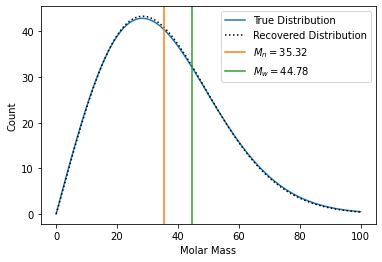

In [49]:
# plot recovered distro and compare
x = np.linspace(0., 100., 101)
scale = 40.
shape = 2.
plt.figure()
plt.plot(x, weib(x, shape, scale, coeff=2000), label='True Distribution')
plt.plot(x, weib(x, recovered_k, recovered_lambda, coeff=2000), label='Recovered Distribution', ls=':', color='k')
y = weib(x, shape, scale)
weib_M_n = np.sum(x*y) / np.sum(y)
plt.axvline(x=weib_M_n, color="C1", label=f'$M_n={weib_M_n:.4}$')
weib_M_w = np.sum(x**2 * y) / np.sum(x*y)
plt.axvline(x=weib_M_w, color="C2", label=f'$M_w={weib_M_w:.4}$')

plt.xlabel('Molar Mass')
plt.ylabel('Count')
plt.legend()
plt.savefig('weibull_mass_dist_recovered.svg')

Great! Now we can package that up into a few functions for recovering our mass distro like so:

In [50]:
def weibull_k_expression(x, Mn, Mw):
    return(2. * x * gamma(2./x)) / gamma(1./x)**2 - (Mw / Mn)

def weibull_lambda_expression(Mn, k):
    return(Mn * k / gamma(1./k))

def recover_mass_dist(Mn=None, Mw=None, pdi=None, distribution='Gaussian'):
    '''This function takes in two of the three quantities [Mn, Mw, PDI],
       and fits either a Gaussian or Weibull distribution of molar masses to them.'''
    if distribution.lower() != 'gaussian' and distribution.lower() != 'weibull':
        raise(ValueError('Distribution must be either "gaussian" or "weibull".'))
    pdi_arg_sum = sum([x is not None for x in [pdi, Mn, Mw]])
    assert pdi_arg_sum >= 2, 'At least two of [pdi, M_n, M_w] must be given.'
    if pdi_arg_sum == 3:
        #special case, make sure that pdi = M_w / M_n
        assert pdi - (Mw/Mn) < 1e-5, 'PDI value does not match M_n and M_w values.'
    else:
        # need to recover one of M_w or M_n or pdi
        if Mn is None:
            Mn = Mw / pdi
        if Mw is None:
            Mw = pdi * Mn
        if pdi is None:
            pdi = Mw / Mn
    if distribution.lower() == 'gaussian':
        mean = Mn
        sigma = Mn * (Mw - Mn)
        return lambda x: np.exp(-(x-Mn)**2 / (2. * sigma))
    elif distribution.lower() == 'weibull':
        # get the shape parameter
        a = scipy.optimize.root(f1, args=(weib_M_n, weib_M_w), x0=1.)
        recovered_k = a['x']
        # get the scale parameter
        recovered_lambda = f2(Mn, recovered_k)
        return lambda x: ( recovered_k / recovered_lambda * (x / recovered_lambda) ** (recovered_k - 1) * np.exp(- (x / recovered_lambda) ** recovered_k) )

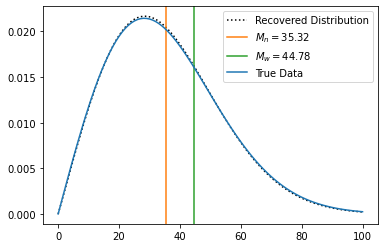

In [51]:
x = np.linspace(0., 100., 101)
scale = 40.
shape = 2.
f = recover_mass_dist(Mn=weib_M_n, Mw=weib_M_w, pdi=None, distribution='weibull')
plt.plot(x, f(x), label='Recovered Distribution', color='k', ls=':')
y = weib(x, shape, scale)
weib_M_n = np.sum(x*y) / np.sum(y)
plt.axvline(x=weib_M_n, color="C1", label=f'$M_n={weib_M_n:.4}$')
weib_M_w = np.sum(x**2 * y) / np.sum(x*y)
plt.axvline(x=weib_M_w, color="C2", label=f'$M_w={weib_M_w:.4}$')
plt.plot(x, y, label='True Data')
plt.legend()

## Comparing Distributions on Real Data

Now let's see how these fit to real data. We have here some .csv files generated by [webplotdigitizer](https://apps.automeris.io/wpd/), from figures taken from Choupin, T. et al. "Macromolecular modifications of ply(etherketoneketone) (PEKK) copolymer at the melting state," _Polymer Degradation and Stability_ **155** (2018), 103-110. This study examined the molar mass distribution of PEKK polymer at various times from 0 to 240 minutes of exposure to heat at 400$^{\circ}$C.

PDI: 1.0346695161194526
4.3825173904536125
0.665878628721637
    fjac: array([[-1.]])
     fun: array([4.4408921e-16])
 message: 'The solution converged.'
    nfev: 15
     qtf: array([-2.60902411e-12])
       r: array([0.01022071])
  status: 1
 success: True
       x: array([6.26508615])
recovered k: [6.26508615]
recovered lambda: [4.7127628]


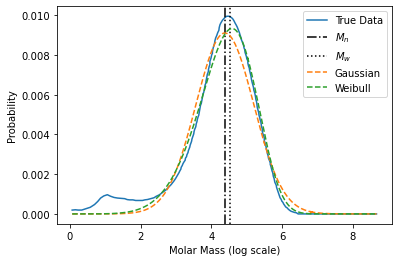

In [58]:
pekk_data_time_0 = np.genfromtxt('PEKK_No_Exposure.csv', delimiter=',')

# clean web plot digitizer data a bit

def filter_y(data_arr, high_cut=1e6, low_cut=5e-3):
    indices = np.where(data_arr[:,1] < low_cut)
    data_arr[indices, 1] = 0
    return data_arr

plt.figure()
data = filter_y(pekk_data_time_0)

x, y = np.log10(data[:,0]), data[:,1]
plt.plot(x,y/np.sum(y), label='True Data')

t0_Mn = np.sum(x*y) / np.sum(y)
t0_Mw = np.sum(x*x*y) / np.sum(x*y)
t0_pdi = t0_Mw / t0_Mn
print('PDI:', t0_pdi)
plt.axvline((t0_Mn), color='k', ls='-.', label='$M_n$')
plt.axvline((t0_Mw), color='k', ls=':', label='$M_w$')

print(t0_Mn)

# Now recover the distribution with both methods
# Gaussian
t0_sig = recovered_gauss_sigma(Mn=(t0_Mn), Mw=(t0_Mw))
print(t0_sig)
gauss_y = gauss((x), mu=(t0_Mn), sigma=t0_sig, N = 1)
plt.plot((x), gauss_y/np.sum(gauss_y), label='Gaussian', ls='--')

# Weibull 
a=scipy.optimize.root(lambda x, y, z: f1((x), y, z), args=((t0_Mn), (t0_Mw)), x0=1.)
print(a)
recovered_k = a['x']
print('recovered k:', recovered_k)
# Now that we have the shape factor, plug it in to the other expression to solve for lambda
# lambda = M_n * k / Gamma(1/k)
recovered_lambda = f2((t0_Mn), recovered_k)
print('recovered lambda:', recovered_lambda)
weib_y = weib(x, recovered_k, recovered_lambda)
plt.plot((x), weib_y/np.sum(weib_y), label='Weibull', ls='--')
plt.xlabel('Molar Mass (log scale)')
plt.ylabel('Probability')
plt.legend()

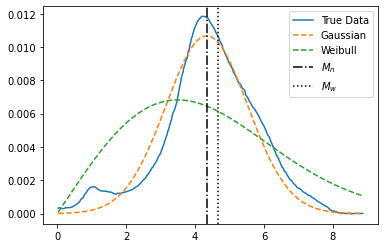

In [59]:
# Same as above, but with data after 2 hours of heating
pekk_data_time_240 = np.genfromtxt('240_Min.csv', delimiter=',')

x, y = np.log10(pekk_data_time_240[:,0]), pekk_data_time_240[:,1]

plt.plot(x, y/np.sum(y), label='True Data')

t240_Mn = np.sum(x*y) / np.sum(y)
t240_Mw = np.sum(x*x*y) / np.sum(x*y)

gauss_f = recover_mass_dist(Mn=t240_Mn, Mw=t240_Mw, pdi=None, distribution='gaussian')
weib_f = recover_mass_dist(Mn=t240_Mn, Mw=t240_Mw, pdi=None, distribution='weibull')

plt.plot(x, gauss_f(x)/np.sum(gauss_f(x)), label='Gaussian', ls='--')
plt.plot(x, weib_f(x)/np.sum(weib_f(x)), label='Weibull', ls='--')

plt.axvline(t240_Mn, ls='-.', color='k', label='$M_n$')
plt.axvline(t240_Mw, ls=':', color='k', label='$M_w$')

plt.legend()
# TODO: Why is the weibull so far off here?
# TODO: Add in an error-checking function and check these directly
# TODO: Digitize the rest of the timesteps from the paper and see how they all compare

## Sampling from Recovered Distributions
Now that we can recover our molar mass distributions, we can sample molar masses directly, which can tell us our polymer length to use in the simulation.